# Iris Clusters

Using Fisher's 1936 set of measurements of three species of the iris flower to look at clustering methods.

### sources

* https://www.kaggle.com/arshid/iris-flower-dataset - where I found the version of ./data/iris.csv that I'm using here.
* https://en.wikipedia.org/wiki/Iris_flower_data_set - a description of the dataset

```
     The data set consists of 50 samples from each of three species of Iris 
     (Iris setosa, Iris virginica and Iris versicolor). Four features were 
     measured from each sample: the length and the width of the sepals and petals, 
     in centimeters. Based on the combination of these four features, Fisher 
     developed a linear discriminant model to distinguish the species from each other.
     ... wikipedia
```

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/440px-Iris_versicolor_3.jpg'>

### notes

* I'm going to use pandas for the basic data management this time around, rather than doing everything from scratch.

Jim Mahoney | April2020

In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

### read in the data

In [2]:
iris = pd.read_csv('./data/iris.csv')
print('\n -- first five rows - raw data -- ')
print(iris[:5])
print('\n -- statistics summary - raw data -- ')
print(iris.describe())


 -- first five rows - raw data -- 
   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

 -- statistics summary - raw data -- 
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.40000

In [3]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

### normalize the columns

In other words, subtract the mean and divide by the standard deviation 
from each column so that they all will have (mean=0, std=1.0)
and therefore the same importance in the later analytic work. 

I'm going to just modify the data in place, discarding the original numbers.

Notice how pandas lets you do numeric operations on the whole column at once.

Also, remove the 'Iris-' from all the species names : that's just annonying.

In [4]:
for feature in features:
    iris[feature] = (iris[feature] - iris[feature].mean()) / iris[feature].std()

iris['species'] = iris['species'].apply(lambda name: name.replace('Iris-', ''));

In [5]:
print('\n -- first five rows - normalized data -- ')
print(iris[:5])
print('\n -- statistics summary - normalized data -- ')
print(iris.describe())


 -- first five rows - normalized data -- 
   sepal_length  sepal_width  petal_length  petal_width species
0     -0.897674     1.028611     -1.336794    -1.308593  setosa
1     -1.139200    -0.124540     -1.336794    -1.308593  setosa
2     -1.380727     0.336720     -1.393470    -1.308593  setosa
3     -1.501490     0.106090     -1.280118    -1.308593  setosa
4     -1.018437     1.259242     -1.336794    -1.308593  setosa

 -- statistics summary - normalized data -- 
       sepal_length   sepal_width  petal_length   petal_width
count  1.500000e+02  1.500000e+02  1.500000e+02  1.500000e+02
mean  -5.684342e-16 -6.158037e-16  1.894781e-16 -1.894781e-16
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -1.863780e+00 -2.430844e+00 -1.563497e+00 -1.439627e+00
25%   -8.976739e-01 -5.858010e-01 -1.223442e+00 -1.177559e+00
50%   -5.233076e-02 -1.245404e-01  3.351431e-01  1.327811e-01
75%    6.722490e-01  5.673506e-01  7.602119e-01  7.879511e-01
max    2.483699e+00  3.104284e+

### define some cluster functions

In [6]:
def cluster_init(iris, k):    
    """ Modify iris in place by creating a 'cluster' column if needed,
        and initializing each cluster value to a random number from 0 to k-1
        where k is the number of clusters. 
        Also store k within iris object as iris.k
        """
    iris.k = k                              # Store value of k.
    iris['cluster'] = None                  # Create the column if it doesn't exist yet.
    # Pick a point at random to be the center of each cluster;
    # then assign the closest to that one to each cluster.
    # (At first I assigned each cluster index to a random number.
    #  But this didn't work out so well ... for large k, 
    #  the points all ended up in the same cluster.)
    centers = []
    for i in range(k):
        i_random = random.randint(0, len(iris)-1)
        centers.append(np.array(iris.iloc[i_random][:4]))  # 1st 4 values are data values
    iris['cluster'] = cluster_closest(iris, centers)

def cluster_center(iris, _k):
    """ Return numpy array of values for one cluster with index _k,
        calculating the center by taking the mean of the rows assigned to that cluster. """
    return np.array([ np.mean(iris[feature][iris['cluster'] == _k]) 
                      for feature in features ])

def cluster_centers(iris):
    """ return cluster centers (mean of assigned points) for the k clusters """
    return np.array([ cluster_center(iris, _k) for _k in range(iris.k) ])

def squared_distance(vector1, vector2):
    """ return squared distance between two numpy vectors """
    return sum( (vector1 - vector2)**2 )

assert squared_distance(np.array([0,0]),          # squared distance from this
                        np.array([3,4])) == 5**2  # to this is 

def closest_index(vector1, vectors):
    """ return i such that vectors[i] has shortest distance to vector1 """
    return np.argmin(np.array( [squared_distance(vector1, _vec) for _vec in vectors] ))

assert closest_index( np.array([0,0,0]),                       # This one,
                      np.array([ [1,1,1], [2,2,2], [3,3,3] ])  # compared to these,
                    ) == 0                                     # is closest to 0'th .

def cluster_closest(iris, centers):
    """ Return list of closest cluster indexes """
    closest = []
    for row in iris.itertuples():
        # see pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.itertuples.html
        #  row columns in this itertuples() are
        #  0         index
        #  1,2,3,4   data values
        #  5         species
        #  6         cluster assignment
        values = np.array( row[1:5] )   # columns are (index, sepal_length, ... )
        closest.append(closest_index(values, centers))
    return np.array(closest)

def cluster_convergence_step(iris):
    """ Run one step of the cluster convergence algorithm,
        modifing the iris['cluster'] values in place. """
    # Find the cluster centers from their assignments
    centers = cluster_centers(iris)
    # Find the index of the closest cluster_position for each row
    closest = cluster_closest(iris, centers)
    # modify the iris data frame in place
    iris['cluster'] = closest       # modify iris dataframe

def clone_clusters(iris):
    """ return a copy of the cluster assignments """
    return list(iris['cluster'])[:]
    
def cluster_algorithm(iris, k, max_steps=100):
    """ modify iris by applying the whole algorithm. Return (steps, status)"""
    cluster_init(iris, k)
    old_clusters = clone_clusters(iris)
    for step in tqdm(range(max_steps)):
        cluster_convergence_step(iris)
        new_clusters = clone_clusters(iris)
        if old_clusters == new_clusters:
            return (step, 'CONVERGED')
    return (max_steps, 'MAX_STEPS_TAKEN')

def squared_cluster_error(iris):
    """ return total squared errors between points and cluster centers """
    result = 0.0
    centers = cluster_centers(iris)
    for row in iris.itertuples():
        values = np.array( row[1:5] )   # see comment in cluster_closest
        i_cluster = row[6]
        result += squared_distance(values, centers[i_cluster])
    return result

def cluster_plot(iris, x_name='sepal_length', y_name='petal_length'):
    """ Draw a plot of the clusters. (step just puts a "step=" into title) """
    plt.figure(dpi=220, figsize=(2.5, 2.5))   # dots_per_inch and (width, height) in inches
    k = iris.k
    plt.title(f'iris clusters k={k}')
    plt.xlabel(x_name.replace('_', ' '), fontsize=8)
    plt.ylabel(y_name.replace('_', ' '), fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    colors = ['red', 'blue', 'green', 'magenta', 'cyan', 'grey', 'darkred', 'darkblue' ]
    centers = cluster_centers(iris)
    for _k in range(k):
        x = iris[x_name][iris.cluster == _k]
        y = iris[y_name][iris.cluster == _k]
        plt.plot(x, y, linestyle='none', marker='.', markersize=2, color=colors[_k])
        i_x = features.index(x_name)  # index for this feature in vector of data values
        i_y = features.index(y_name)
        plt.annotate(s=str(_k), xy=(centers[_k][i_x], centers[_k][i_y]), color=colors[_k], fontsize=8)


### First round of testing, stepping through the algorithm with printing

In [7]:
k = 3

cluster_init(iris, k)
print(iris[:10])
print()
print(f'cluster {1} position for \n{features} is \n{cluster_center(iris, 1)}')

   sepal_length  sepal_width  petal_length  petal_width species  cluster
0     -0.897674     1.028611     -1.336794    -1.308593  setosa        2
1     -1.139200    -0.124540     -1.336794    -1.308593  setosa        2
2     -1.380727     0.336720     -1.393470    -1.308593  setosa        2
3     -1.501490     0.106090     -1.280118    -1.308593  setosa        2
4     -1.018437     1.259242     -1.336794    -1.308593  setosa        2
5     -0.535384     1.951133     -1.166767    -1.046525  setosa        2
6     -1.501490     0.797981     -1.336794    -1.177559  setosa        2
7     -1.018437     0.797981     -1.280118    -1.308593  setosa        2
8     -1.743017    -0.355171     -1.336794    -1.308593  setosa        2
9     -1.139200     0.106090     -1.280118    -1.439627  setosa        2

cluster 1 position for 
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'] is 
[1.33309267 0.06124517 0.97746923 0.90806558]


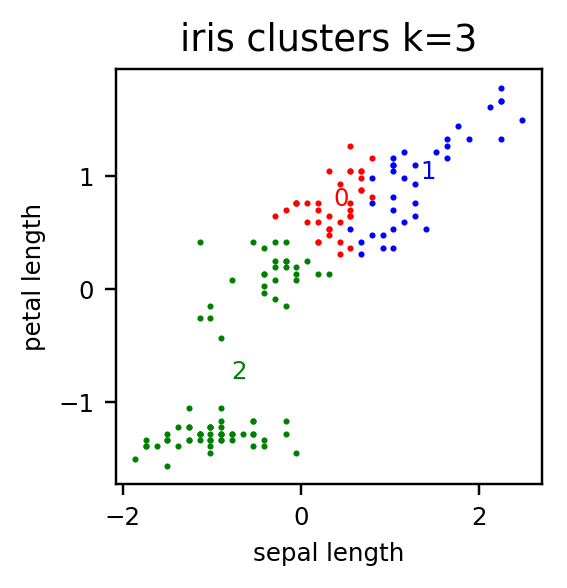

In [8]:
# initial random assignment

cluster_plot(iris)

In [9]:
# printing out assignments and centers for each step

for i in range(5):
    print('----- step ', i)
    print('first 10 cluster assignments: ', list(iris['cluster'][:10]))    

    centers = cluster_centers(iris)
    print('cluster centers are')
    print(centers)
    
    closest_centers = cluster_closest(iris, centers)
    print('closest centers are')
    print(closest_centers)
    
    print('reassigning clusters')
    iris['cluster'] = closest_centers

----- step  0
first 10 cluster assignments:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
cluster centers are
[[ 0.36363172 -0.47689228  0.73974559  0.79887058]
 [ 1.33309267  0.06124517  0.97746923  0.90806558]
 [-0.78310357  0.19183713 -0.79256068 -0.78781669]]
closest centers are
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 1 0 0 0 1 2 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 2 0 1 0 1 0 1 1 0 1 0 1 1
 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1
 1 0]
reassigning clusters
----- step  1
first 10 cluster assignments:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
cluster centers are
[[ 0.1388778  -0.70880389  0.46077454  0.397033  ]
 [ 1.28612917  0.20859232  1.0687803   1.10097674]
 [-1.01172811  0.64849833 -1.2244919  -1.17513227]]
closest centers are
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1

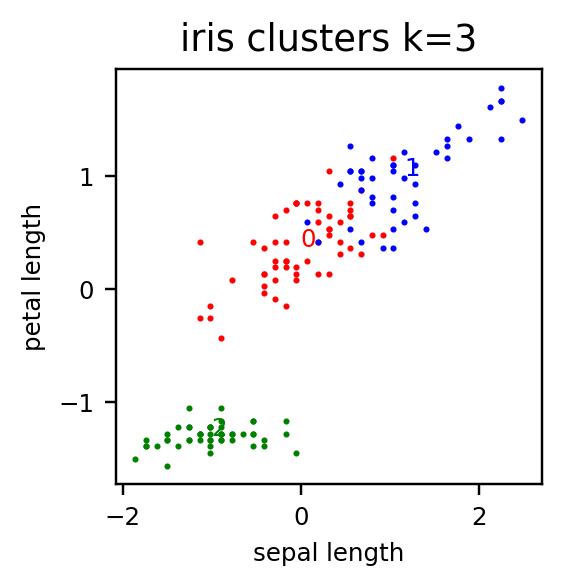

In [10]:
# and here's what we get

cluster_plot(iris)

... which looks like it's working.

### more testing

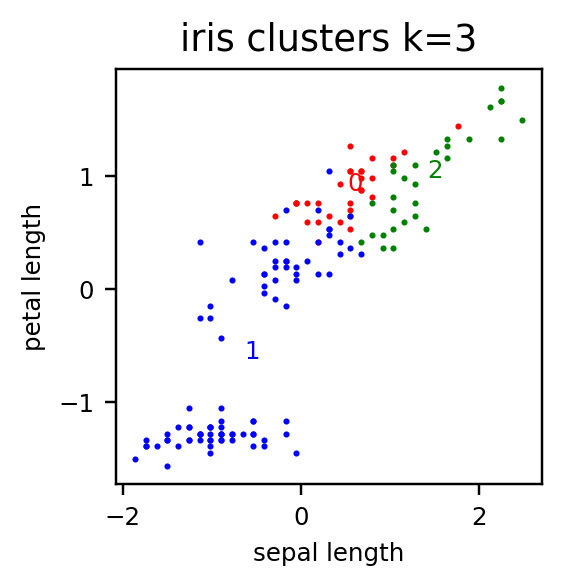

In [11]:
# re-initialize to a random assignment

k = 3
cluster_init(iris, k)
cluster_plot(iris)

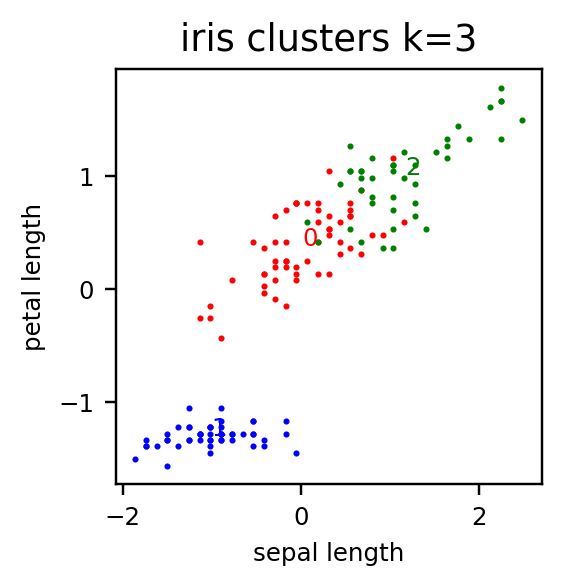

In [12]:
# take 5 steps

for i in range(5):
    cluster_convergence_step(iris)
cluster_plot(iris)

### and yet more testing

100%|██████████| 500/500 [00:13<00:00, 36.88it/s]


result='MAX_STEPS_TAKEN' in steps=500


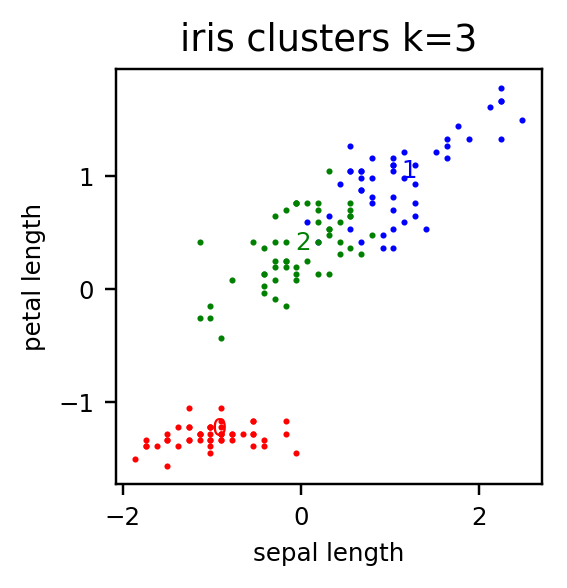

In [13]:
(steps, result) = cluster_algorithm(iris, 3, max_steps=500)
print(f"result='{result}' in steps={steps}")
cluster_plot(iris)

I've done several iterations ... and found very different results depending on the starting state.

Sometimes there are two clusters in the bottom clump, other times two in the top clump.
Though when I tried to repeat that result, most of what I got looked like the one above.

Perhaps do multiple times & average somehow? Or vote on ones that look similar?

Dunno.

### Finally, let's try several values of k.

  6%|▌         | 6/100 [00:00<00:01, 57.75it/s]


 k=1 result=CONVERGED steps=0 error=596.0000000000001



  4%|▍         | 4/100 [00:00<00:02, 39.16it/s]

 k=2 result=MAX_STEPS_TAKEN steps=100 error=222.2404590318517



  4%|▍         | 4/100 [00:00<00:02, 34.40it/s]

 k=3 result=MAX_STEPS_TAKEN steps=100 error=141.16323288350162



  3%|▎         | 3/100 [00:00<00:04, 22.76it/s]

 k=4 result=MAX_STEPS_TAKEN steps=100 error=114.96361832770611



  6%|▌         | 6/100 [00:00<00:03, 25.00it/s]

 k=5 result=MAX_STEPS_TAKEN steps=100 error=103.99153409204018



  2%|▏         | 2/100 [00:00<00:05, 19.60it/s]

 k=6 result=MAX_STEPS_TAKEN steps=100 error=96.59771035224139



  2%|▏         | 2/100 [00:00<00:07, 13.71it/s]

 k=7 result=MAX_STEPS_TAKEN steps=100 error=76.30014801600706



  2%|▏         | 2/100 [00:00<00:05, 17.39it/s]

 k=8 result=MAX_STEPS_TAKEN steps=100 error=63.11837689457413



  4%|▍         | 4/100 [00:00<00:05, 16.17it/s]

 k=9 result=MAX_STEPS_TAKEN steps=100 error=596.0000000000001
  ... all in one cluster ... trying again


  2%|▏         | 2/100 [00:00<00:06, 15.44it/s]

 k=9 result=MAX_STEPS_TAKEN steps=100 error=596.0000000000001
  ... all in one cluster ... trying again


100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


 k=9 result=MAX_STEPS_TAKEN steps=100 error=62.24248928634879


Text(0, 0.5, 'error')

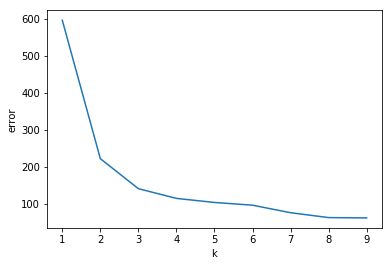

In [14]:
errors = []
for k in range(1, 10):
    print()
    attempt = 0
    while attempt < 10:
        (steps, result) = cluster_algorithm(iris, k)  # initilize data & run algorithm.
        attempt += 1
        error = squared_cluster_error(iris)           
        print(f' k={k} result={result} steps={steps} error={error}')
        if k==1 or error<500:
            break
        else:
            print('  ... all in one cluster ... trying again')
    errors += [error]

plt.plot(range(1, k+1), errors)
plt.xlabel('k')
plt.ylabel('error')



... which is something like the "knee" plots discussed in the text.

As you see in the code, sometimes the algorithm would have all
of the points fall into one cluster and get stuck, giving
a high error - the same as k=1. I modified the code to 
try again for those cases, up to 10 times.

The true number is k=3, but visually (at least for what I plotted) k=2 
also doesn't look bad. The plot *maybe* suggests this ... YMMV.

;)